## Build a basic ChatBot using LangGraph (GRAPH API)

In [112]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [113]:
class State(TypedDict):
    # Messages have the type "list". The add_messages function 
    #in the annotation defines how this state key should be updated
    messages:Annotated[list,add_messages]


In [114]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [115]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model='llama3-8b-8192')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7cfa531f05c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7cfa531f0ec0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [116]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7cfa531f0a10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7cfa531e8f20>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [117]:
## Node Functionality
def chatbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]}

In [118]:
graph_builder = StateGraph(State)

## Adding Node
graph_builder.add_node("llmchatbot",chatbot)

## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## Compile the GRAPH
graph=graph_builder.compile()

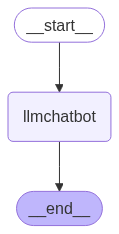

In [119]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [120]:
response = graph.invoke({"messages":"Hi"})

In [121]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [122]:
for event in graph.stream({"messages":"Hi how are you doing today"}):
    for value in event.values():
        print(value['messages'][-1].content)

I'm just a language model, I don't have emotions or feelings like humans do, so I don't have good or bad days. I'm always "on" and ready to assist you with any questions or tasks you may have! It's great to chat with you, though. How about you? How's your day going so far?


## Chatbot With Tool

In [123]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("Latest in AI field")

{'query': 'Latest in AI field',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'AI News & Artificial Intelligence | TechCrunch',
   'url': 'https://techcrunch.com/category/artificial-intelligence/',
   'content': 'Read the latest on artificial intelligence and machine learning tech, the companies that are building them, and the ethical issues AI raises today.',
   'score': 0.56489134,
   'raw_content': None},
  {'title': 'Artificial Intelligence News -- ScienceDaily',
   'url': 'https://www.sciencedaily.com/news/computers_math/artificial_intelligence/',
   'content': 'Artificial Intelligence News. Everything on AI including futuristic robots with artificial intelligence, computer models of human intelligence and more.',
   'score': 0.47270843,
   'raw_content': None}],
 'response_time': 1.6}

In [124]:
### Custom Tools
def multiply(a:int, b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int value
        b (int): Secount int value

    Returns:
        out (int): final_output int value
    """
    return a*b

In [125]:
tools=[tool,multiply]
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7cfa531f0a10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7cfa531e8f20>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domai

In [126]:
## Buildig a StateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [127]:
## Node definition
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

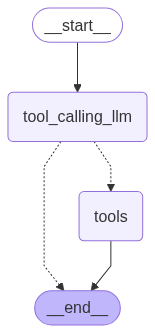

In [128]:
## Build a graph
builder = StateGraph(State)

## Add nodes
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest (message) from the assistant is a tool call -> tools_condition routes to tool
    # If the latest (message) from the assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## Compile the graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [129]:
response = graph.invoke({"messages":"What is the Latest AI News"})
response['messages'][-1].content

'{"query": "Latest AI News", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ptechpartners.com/2025/07/01/emerging-ai-news-roundup-for-may-and-june-2025-part-1-ai-agents-jobs-impact-and-the-return-of-the-surge/", "title": "Emerging AI News Roundup for May and June 2025 Part 1", "content": "Explore the biggest AI news from May and June 2025, including breakthroughs in AI agents, the evolving impact on jobs, and a renewed surge in AI innovation.", "score": 0.74961954, "raw_content": null}, {"title": "AI is advancing even faster than sci-fi visionaries like Neal ...", "url": "https://www.yahoo.com/news/ai-advancing-even-faster-sci-123123199.html", "content": "Three recent developments in AI – in video games, wearable technology and education – reveal that building something like the Primer should no longer be considered the purview of science fiction.\\n\\nIn May 2025, the hit video game “Fortnite” introduced an AI version of Darth Vader, who sp

In [130]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

What is the Latest AI News
================================== Ai Message ==================================
Tool Calls:
  tavily_search (t8hpy7cpm)
 Call ID: t8hpy7cpm
  Args:
    exclude_domains: []
    include_domains: []
    include_images: False
    query: Latest AI News
    search_depth: advanced
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Latest AI News", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ptechpartners.com/2025/07/01/emerging-ai-news-roundup-for-may-and-june-2025-part-1-ai-agents-jobs-impact-and-the-return-of-the-surge/", "title": "Emerging AI News Roundup for May and June 2025 Part 1", "content": "Explore the biggest AI news from May and June 2025, including breakthroughs in AI agents, the evolving impact on jobs, and a renewed surge i

In [131]:
response = graph.invoke({"messages":"What is the 5 multiplation of 5"})

for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

What is the 5 multiplation of 5
================================== Ai Message ==================================
Tool Calls:
  multiply (yjvgnydhn)
 Call ID: yjvgnydhn
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: multiply

25


### ReAct Agent Architecture 

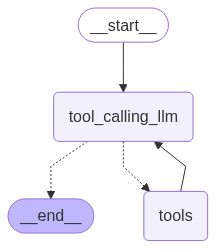

In [132]:
## Build a graph
builder = StateGraph(State)

## Add nodes
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest (message) from the assistant is a tool call -> tools_condition routes to tool
    # If the latest (message) from the assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## Compile the graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
response = graph.invoke({"messages":"Give me the recent AI news and then multiply 5 by 5"})

for msg in response['messages']:
    msg.pretty_print()

### Adding Memory In Agentic Graph

In [ ]:
response = graph.invoke({"messages":"Hello, My name is Agent Chatbot"})

for msg in response['messages']:
    msg.pretty_print()

In [ ]:
response = graph.invoke({"messages":"What is my name?"})

for msg in response['messages']:
    msg.pretty_print()

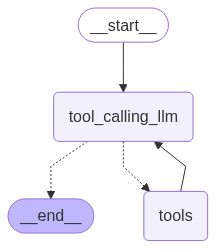

In [134]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Build a graph
builder = StateGraph(State)

## Add nodes
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest (message) from the assistant is a tool call -> tools_condition routes to tool
    # If the latest (message) from the assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## Compile the graph
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [135]:
configration={"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hello, My name is Agent Chatbot"}, config=configration)

for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

Hello, My name is Agent Chatbot
================================== Ai Message ==================================

Nice to meet you, Agent Chatbot! I'm happy to assist you with any questions or tasks you may have. What would you like to talk about or accomplish today?


In [ ]:
response = graph.invoke({"messages":"What is my name"}, config=configration)

for msg in response['messages']:
    msg.pretty_print()

## Streaming

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [ ]:
def superbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]}

In [ ]:
## Build a graph
builder = StateGraph(State)

## Add nodes
builder.add_node("superbot",superbot)

## Add Edges
builder.add_edge(START,"superbot")
builder.add_edge("superbot",END)

## Compile the graph
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
configration={"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hello, My name is Agent and i like painting"}, configration)

for msg in response['messages']:
    msg.pretty_print()

In [ ]:
config={"configurable":{"thread_id":"1"}}

for chunk in graph.stream({"messages":"Hello, My name is Alley and i like painting"}, config, stream_mode="updates"):
    print(chunk)

In [ ]:
config={"configurable":{"thread_id":"1"}}

for chunk in graph.stream({"messages":"Hello, My name is Alley and i like painting"}, config, stream_mode="values"):
    print(chunk)

In [ ]:
configration={"configurable":{"thread_id":"2"}}

for chunk in graph.stream({"messages":"Hello, My name is Alley and i like swimming"}, configration, stream_mode="updates"):
    print(chunk)

In [ ]:
for chunk in graph.stream({"messages":"i also like volleyball"}, configration, stream_mode="values"):
    print(chunk)

In [ ]:
config_5={"configurable":{"thread_id":"5"}}

async for event in graph.astream_events({"messages":"Hello, My name is Alley and i like swimming"}, config_5, version="v2"):
    print(event)

### Human in the Loop

In [136]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query:str)-> str:
    """Request assistance from a human"""
    human_response = interrupt({"query" : query})
    return human_response['data']

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools1 = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools1.invoke(state['messages'])
    # Because we will be interrupting during execution,
    # we disable parallel tool calling to avoid repeat any
    # tool invocations when it resumed

    return {'messages':[message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools = tools)

graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools","chatbot")


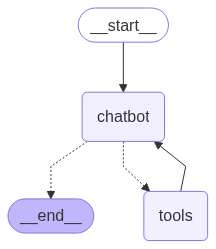

In [137]:
## Compile the graph
graph = graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [138]:
user_input = "I need some expert guidance and assistance on building AI agent, Could you request assistance for me?"
config_2 = {"configurable":{"thread_id":15}}


events = graph.stream(
    {"messages" : user_input},
    config_2,
    stream_mode='values',
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance on building AI agent, Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kxe4syvsv)
 Call ID: kxe4syvsv
  Args:
    query: expert guidance and assistance on building AI agent
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "expert guidance and assistance on building AI agent", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "How to Build an AI Agent: Step-by-Step Guide | Anjin AI Insights", "url": "https://www.anjin.digital/blog-posts/how-to-build-an-ai-agent-guide", "content": "Learn how to build an AI agent from scratch using cutting-edge techniques. This expert guide explores tools, architecture, use cases and deployment, optimised for search and gener

In [140]:
human_response = (
    "We the experts are here to help you, We'd recommend yoy to check the Langgraph to build your agent."
    "It's much more reliable and extensible than simple autonomus agents."
)

human_command = Command(resume={"data":human_response})

events = graph.stream(human_command, config_2, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on the results from the tool call id "kxe4syvsv", I would like to request further assistance from the user to provide more context and clarify their needs.

Please provide more information about what kind of expert guidance and assistance you are looking for in building an AI agent. For example, what specific areas of AI agent development are you struggling with? Are you looking for help with choosing the right tools, designing the architecture, or implementing the AI agent?

Additionally, please let me know if you would like to explore any of the search results provided by the tool call id "kxe4syvsv", such as the articles "How to Build an AI Agent: Step-by-Step Guide | Anjin AI Insights" or "How to Build an AI Agent That Actually Works In 2025".
